# Adaptive Distances

In this example, we show how and when to use the adaptive distances feature of pyabc. "Adaptive distances" means that the distance function is not pre-defined (e.g. after pre-processing), but evolves over time during the ABC run, depending on the observed summary statistics. This can be useful if different summary statistics vary on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights are adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented in pyABC, but it is easily possible to define arbitrary adaptive distances.

For illustration, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1 * scipy.randn(),
            'ss2': 2 + 10 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/utils.py:134: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)

abc.new(db_path, observation)

history0 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=1, start_time=2019-09-25 08:06:56.064009, end_time=None)>
INFO:Epsilon:initial epsilon is 7.0067891676223875
INFO:ABC:t:0 eps:7.0067891676223875
INFO:ABC:t:1 eps:4.000955683917402
INFO:ABC:t:2 eps:2.73144340001823
INFO:ABC:t:3 eps:1.7120910600931485
INFO:ABC:t:4 eps:1.229098931977589
INFO:ABC:t:5 eps:0.8463007250244399
INFO:ABC:t:6 eps:0.5534396230194484
INFO:ABC:t:7 eps:0.42037990491632116
INFO:History:Done <ABCSMC(id=1, start_time=2019-09-25 08:06:56.064009, end_time=2019-09-25 08:07:16.372356)>


Let us visualize the results for the non-adaptive distance:

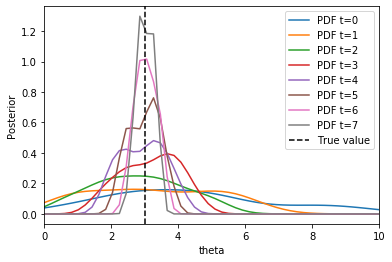

In [9]:
# plotting

def plot(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()


plot(history0)

Second, we consider an adaptive Euclidean distance:

In [4]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)

abc.new(db_path, observation)

history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=2, start_time=2019-09-25 08:07:16.799997, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 1.527701398905977, 'ss2': 0.4722986010940229}
INFO:Epsilon:initial epsilon is 5.719585479962741
INFO:ABC:t:0 eps:5.719585479962741
DEBUG:Distance:updated weights[1] = {'ss1': 1.5874001166007239, 'ss2': 0.4125998833992763}
INFO:ABC:t:1 eps:3.381421240799253
DEBUG:Distance:updated weights[2] = {'ss1': 1.6955592675304898, 'ss2': 0.3044407324695103}
INFO:ABC:t:2 eps:2.053548808657679
DEBUG:Distance:updated weights[3] = {'ss1': 1.8013813140687795, 'ss2': 0.1986186859312205}
INFO:ABC:t:3 eps:1.2513216437871508
DEBUG:Distance:updated weights[4] = {'ss1': 1.8844724967912792, 'ss2': 0.11552750320872084}
INFO:ABC:t:4 eps:0.7064909139632751
DEBUG:Distance:updated weights[5] = {'ss1': 1.9182177599900143, 'ss2': 0.08178224000998577}
INFO:ABC:t:5 eps:0.43813868935367517
DEBUG:Distance:updated weights[6] = {'ss1': 1.9463857842161862, 'ss2': 0.05361421578381358}
INFO:ABC:

In the debug output of abc.run above, it can be seen how the weights evolve over time. Note that we set the acceptor to ``pyabc.acceptor.accept_use_complete_history`` instead of the default ``pyabc.acceptor.accept_use_current_time`` in order to get nested acceptance regions. This is optional here but may be beneficial sometimes. Let us visualize the results for the adaptive distance:

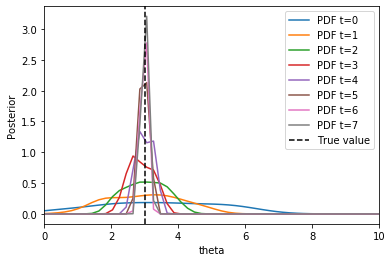

In [10]:
plot(history1)

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$. In addition, despite, the better convergence, the required number of samples in total is lower, as not so much time was wasted trying to match an uninformative summary statistic:

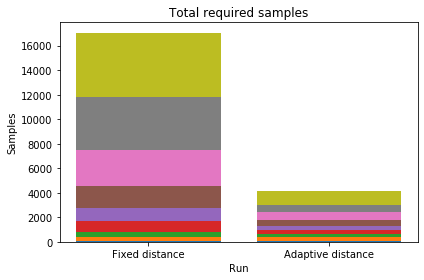

In [11]:
pyabc.visualization.plot_sample_numbers([history0, history1], ["Fixed distance", "Adaptive distance"])

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a sample from the prior), the method ``DistanceFunction.update()`` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via ``DistanceFunction.configure_sampler()``, the distance function can tell the sampler to not only record accepted particles, but all that were generated during the sampling process.
So, when you want to define your own adaptive distance function, you will typically only need to overwrite these two methods. For implementation details and an example of how this can look in practice, please inspect the code of ``AdaptivePNormDistance``.

## Make it robust

A problem with the previous adaptive distance occurs when the weights do not work properly. E.g., there could be large weights assigned to rather non-informative statistics, if these vary comparably little. Let us have a look at an example:

In [31]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 1 * scipy.randn(),
            'ss2': 2 + 0.01 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 5}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")


# plotting

def plot(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()

Essentially, we changed the variances of the two summary statistics, and in addition we shifted the observed value `ss2` to 5, which can be interpreted as a measurement error. Now the problem is that this value is highly unlikely to sample from under the model, and when using adaptive weights, this statistic might due to the small variance be assigned a high weight, worsening the problem.

INFO:History:Start <ABCSMC(id=65, start_time=2019-09-25 10:33:54.281756, end_time=None)>
INFO:Epsilon:initial epsilon is 3.6555762976729445
INFO:ABC:t:0 eps:3.6555762976729445
INFO:ABC:t:1 eps:3.162047102108326
INFO:ABC:t:2 eps:3.042314158664639
INFO:ABC:t:3 eps:3.009761691534231
INFO:ABC:t:4 eps:3.0005352289235354
INFO:ABC:t:5 eps:2.9943722247335867
INFO:ABC:t:6 eps:2.9905249758645733
INFO:ABC:t:7 eps:2.986639437283908
INFO:History:Done <ABCSMC(id=65, start_time=2019-09-25 10:33:54.281756, end_time=2019-09-25 10:34:27.778510)>


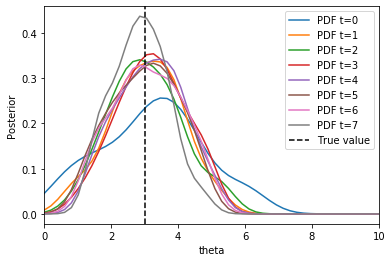

In [32]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(db_path, observation)
history0 = abc.run(minimum_epsilon=.001, max_nr_populations=8)

plot(history0)

INFO:History:Start <ABCSMC(id=66, start_time=2019-09-25 10:34:30.400303, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 0.006280216422645297, 'ss2': 1.9937197835773548}
INFO:Epsilon:initial epsilon is 5.979250120426485
INFO:ABC:t:0 eps:5.979250120426485
DEBUG:Distance:updated weights[1] = {'ss1': 0.006952246659252826, 'ss2': 1.9930477533407471}
INFO:ABC:t:1 eps:5.965757944491175
DEBUG:Distance:updated weights[2] = {'ss1': 0.007082022817400033, 'ss2': 1.9929179771826}
INFO:ABC:t:2 eps:5.954440311034617
DEBUG:Distance:updated weights[3] = {'ss1': 0.006725236263782735, 'ss2': 1.9932747637362174}
INFO:ABC:t:3 eps:5.9481978226820695
DEBUG:Distance:updated weights[4] = {'ss1': 0.006968034216088399, 'ss2': 1.9930319657839117}
INFO:ABC:t:4 eps:5.9408934591784455
DEBUG:Distance:updated weights[5] = {'ss1': 0.00746086959640169, 'ss2': 1.9925391304035982}
INFO:ABC:t:5 eps:5.932896269371143
DEBUG:Distance:updated weights[6] = {'ss1': 0.007650211524705736, 'ss2': 1.9923497884752943}
IN

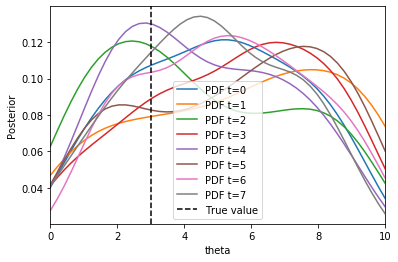

In [33]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.001, max_nr_populations=8)

plot(history1)

These results are as expeted: The adaptive weights make the situation much worse. Our solution is to in addition to the in-sample variance also take te bias of the samples to the observed data into account, using e.g. the `root_mean_square_deviation` as scale function.

INFO:History:Start <ABCSMC(id=67, start_time=2019-09-25 10:36:30.156140, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 0.9101238433973955, 'ss2': 1.0898761566026045}
INFO:Epsilon:initial epsilon is 3.8721985549960785
INFO:ABC:t:0 eps:3.8721985549960785
DEBUG:Distance:updated weights[1] = {'ss1': 0.9064631572136013, 'ss2': 1.093536842786399}
INFO:ABC:t:1 eps:3.416913625472556
DEBUG:Distance:updated weights[2] = {'ss1': 1.2759640429697423, 'ss2': 0.7240359570302576}
INFO:ABC:t:2 eps:2.285030052713774
DEBUG:Distance:updated weights[3] = {'ss1': 1.3280241691619195, 'ss2': 0.6719758308380805}
INFO:ABC:t:3 eps:2.0516787460618975
DEBUG:Distance:updated weights[4] = {'ss1': 1.2847683040696678, 'ss2': 0.7152316959303323}
INFO:ABC:t:4 eps:2.1526790559010465
DEBUG:Distance:updated weights[5] = {'ss1': 1.346850958586394, 'ss2': 0.653149041413606}
INFO:ABC:t:5 eps:1.9607266300170856
DEBUG:Distance:updated weights[6] = {'ss1': 1.4036442697912452, 'ss2': 0.596355730208755}
INFO:ABC:t:6 

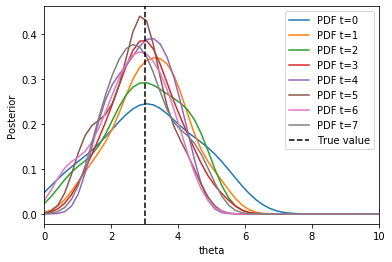

In [34]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2, scale_function=pyabc.distance.root_mean_square_deviation)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.001, max_nr_populations=8)

plot(history2)

The accuracy is back to the non-weighted case. In addition, slightly smaller weights are assigned to the second summary statistic, corresponding to a slight decrease in the total number of samples, as the following plot shows. Applying this method the first model shows that it is also applicable there, though potentially slightly less efficient. This demonstrates that this method is more robust in taking model error into account, which in practice can easily occur.

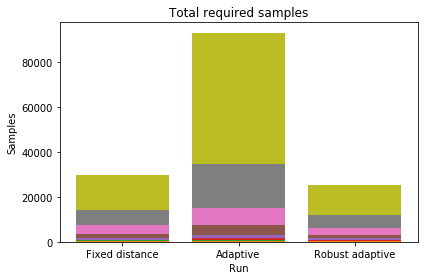

In [35]:
pyabc.visualization.plot_sample_numbers([history0, history1, history2], ["Fixed distance", "Adaptive", "Robust adaptive"])

## Take information content into account

There is still one problem with the shown methods: What if in the second model we do not introduce a model error, but just decrease the relative variance of the second summary statistic? In this case, one could expect that all of the above adaptive methods assign high weights to `ss1`, although this statistic is obviously not informative of the parameters. So our final goal is to not only take variance of the simulations or bias to the data into account, but explicitly account for the information content of the summary statistics w.r.t. the parameters.